In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [3]:
model = TFBertModel.from_pretrained("bert-base-multilingual-cased", output_hidden_states = True)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
def encode(sents, tokenizer):
    input_ids = []
    attention_mask = []
    for text in sents:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=20,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_mask.append(tokenized_text['attention_mask'])
    return tf.convert_to_tensor(input_ids, dtype=tf.int32), tf.convert_to_tensor(attention_mask, dtype=tf.int32)

In [5]:
with open('Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [29]:
sum(labels)/len(labels)

0.5248754413969913

In [6]:
tokenized_sents = encode(texts[:2000], tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [7]:
for layer in model.layers:
    layer.trainable=False

In [8]:
outputs = model(tokenized_sents[0], attention_mask = tokenized_sents[1])

In [9]:
outputs[2][-1].shape

TensorShape([2000, 20, 768])

In [10]:
hidden_states = outputs[2][-1]
features = hidden_states[:,0,:].numpy()

In [11]:
# outputs[0]도 12번째 encoder block 정보를 담고 있음, 아래와 같이 코딩하는 것도 가능
# outputs[0].shape
# hidden_states1 = outputs[0]
# features1 = hidden_states[:,0,:].numpy()

In [12]:
len(features)

2000

In [13]:
features[0]

array([-1.95776939e-01, -1.42887294e-01, -7.39764571e-02,  2.25616604e-01,
        1.69666678e-01, -2.31547393e-02,  8.91063809e-02, -9.06203687e-03,
       -1.60783678e-01,  3.93733829e-01, -1.15178823e-01,  1.41906321e-01,
        2.62128115e-01,  3.43998522e-02, -4.72594380e-01, -4.14408267e-01,
       -4.52963263e-02,  1.72259539e-01,  2.02932626e-01,  4.96088266e-01,
        1.68717712e-01,  1.16876006e-01,  7.71853030e-02,  1.10295400e-01,
        7.44942501e-02,  7.94510171e-02,  3.70397151e-01, -2.17554048e-02,
        6.41099811e-01,  2.70394534e-01,  1.28989473e-01, -2.26351023e-02,
       -1.99827209e-01,  2.01245576e-01, -2.33793855e-01,  4.83464524e-02,
       -1.89987814e+00, -1.58275172e-01, -2.73916423e-02,  7.47385025e-02,
       -3.49226654e-01, -9.15706158e-02, -9.44415852e-02,  2.38769248e-01,
        1.50228709e-01,  9.70730662e-01,  4.60561961e-02,  4.32114378e-02,
        1.49612212e+00, -1.95974424e-01,  2.01177359e-01, -4.21490669e-01,
        4.72220182e-02, -

In [14]:
selected_labels=labels[:2000]

In [15]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, selected_labels, test_size=0.2, random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=1000)
lr2.fit(train_features, train_labels)
pred_labels = lr2.predict(test_features)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)

0.6775

### FNN 사용해 보기

In [18]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(selected_labels)

In [19]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(features, y_one_hot, test_size=0.2)

In [20]:
from tensorflow.keras import models
model = models.Sequential()

In [21]:
from tensorflow.keras import layers
model.add(layers.Dense(64, activation = 'tanh', input_shape=(X_train.shape[1],)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'tanh'))
model.add(layers.Dense(2, activation='softmax'))

In [22]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
40/40 [==============================] - 0s 6ms/step - loss: 0.7008 - accuracy: 0.4922 - val_loss: 0.6881 - val_accuracy: 0.5344
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5734 - val_loss: 0.6730 - val_accuracy: 0.5719
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6070 - val_loss: 0.6611 - val_accuracy: 0.6281
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6203 - val_loss: 0.6530 - val_accuracy: 0.6500
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6320 - val_loss: 0.6478 - val_accuracy: 0.6406
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6562 - val_loss: 0.6416 - val_accuracy: 0.6375
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6656 - val_loss: 0.6473 - val_accuracy: 0.5906
Epoch 8/100
4

Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4717 - accuracy: 0.7750 - val_loss: 0.6815 - val_accuracy: 0.6187
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4711 - accuracy: 0.7828 - val_loss: 0.6628 - val_accuracy: 0.6531
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4685 - accuracy: 0.7797 - val_loss: 0.6698 - val_accuracy: 0.6500
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4631 - accuracy: 0.7875 - val_loss: 0.6670 - val_accuracy: 0.6531
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.7844 - val_loss: 0.6640 - val_accuracy: 0.6531
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7859 - val_loss: 0.6686 - val_accuracy: 0.6594
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4580 - accuracy: 0.7844 - val_loss: 0.6800 - val_accuracy: 0.6250
Epoch 

In [24]:
model.evaluate(X_test,y_test)[1]

13/13 [==============================] - 0s 1ms/step - loss: 0.7237 - accuracy: 0.6500


0.6499999761581421

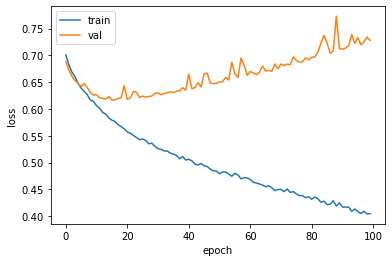

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

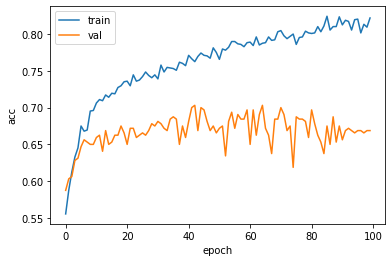

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

## BoW 모형 사용해보기

In [30]:
selected_texts = texts[:2000]

In [31]:
# To split the data into training and test datasets
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(selected_texts, selected_labels, test_size=0.2, random_state=0)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1)) 
train_tf_features = tf_vectorizer.fit_transform(train_texts)
test_tf_features = tf_vectorizer.transform(test_texts)

In [33]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=2000)
lr2.fit(train_tf_features, train_labels) # 학습
pred_labels = lr2.predict(test_tf_features)

In [34]:
from sklearn.metrics import accuracy_score
print('Misclassified samples: {} out of {}'.format((pred_labels != test_labels).sum(),len(test_labels)))
print('Accuracy: %.2f' % accuracy_score(test_labels, pred_labels))

Misclassified samples: 93 out of 400
Accuracy: 0.77
